# Lab 3 Hiroshi-Ishikawa 

In [1]:
import copy
import numpy as np

from numpy.random import shuffle
from numba import njit
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm

import funcs as f
import utils as utl

---

## Input

Input size:  (3, 3)
dtype: uint8 | max: 184 | min: 55


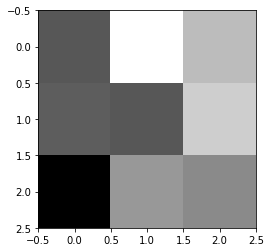

In [2]:
C = np.array([ 0, 128, 255])
binary_penalty = 70
shape = (3,3)
img = utl.import_img("input.png", bw=True, newshape=shape)

In [3]:
@njit
def init_g(img, C, betta):
    
    h, w = img.shape[:2]
    img = img.flatten()
    csize = C.size

    g = np.zeros((h*w*csize + 2, h*w*csize + 2), dtype = np.float32)

    
    
    # S -> first layer
    g[0, 1:h*w] = np.inf

    # last layer -> E
    g[-h*w-1:-1, -1] = np.abs(C[-1] - img)

    # neighbours
    for k in range(C.size):
        for i in range(h):
            for j in range(w):
                
                index = j + i*w + 1 + k*w*h
                pixel_color = img[j + i*w]
                
                
                # left
                if j > 0:
                    left = j - 1 + i*w + 1 + k*w*h
                    g[index, left] = betta
                    
                # right
                if j < w - 1:
                    right = j + 1 + i*w + 1 + k*w*h
                    g[index, right] = betta

                # up
                if i > 0:
                    up = j + (i-1)*w + 1 + k*w*h
                    g[index, up] = betta

                # down
                if i < h - 1:
                    down = j + (i+1)*w + 1 + k*w*h
                    g[index, down] = betta

                # upper layer
                if k < 2:
                    up_l = j + i*w + 1 + (k+1)*w*h
                    g[index, up_l] = np.abs(C[k] - pixel_color)

                # bottom layer
                if k > 0:
                    up_l = j + i*w + 1 + (k-1)*w*h
                    g[index, up_l] = np.inf           
                
    return g

#print(f"k: {k} | i,j: {i,j} | index: {index} | pixel_ind: {j+i*w}")

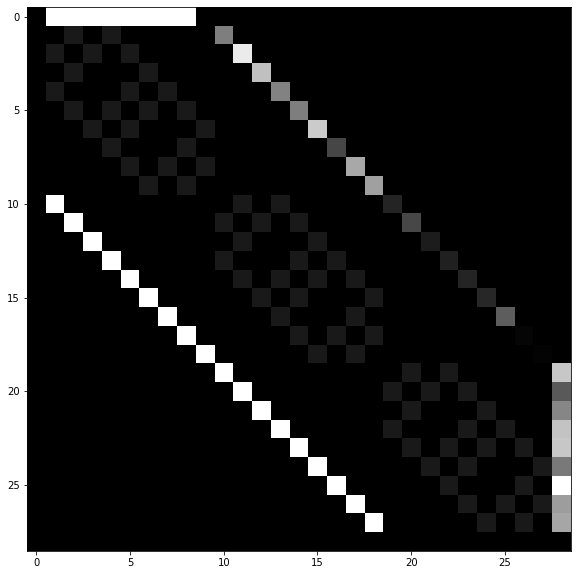

In [4]:
g = init_g(img, C, betta=20)
plt.subplots(figsize=(10, 10))
plt.imshow(g, cmap='gray')

---

In [5]:
#@njit
def iteration(G, F):
    
    Prev = np.full(Vsize, -1) # Prev node
    Q = [0] # Queue
    cursor = 0 # instead of popping elements of of the Q

    while cursor < Vsize:

        v_curr = Q[cursor]
        for v_ind, capacity in enumerate( G[v_curr] ):
            if F[v_curr, v_ind] < capacity and Prev[v_ind] == -1 and v_ind != v_curr:
                Q.append(v_ind)
                Prev[v_ind] = v_curr

        cursor += 1
        if cursor >= len(Q) : break

    # path reconstruction
    v_curr = Vsize - 1
    path = [v_curr]
    while True:
        v_prev = Prev[v_curr]
        v_curr = v_prev
        if v_curr == -1 : break
        path.append(v_curr)

    path = path[::-1]
    
    
    
    # path bottleneck
    bottleneck = np.inf # float('inf') doesn't work with numba
    for i in range(len(path) - 1):
        v_curr = path[i]
        v_next = path[i+1]

        local_w = G[v_curr, v_next] - F_[v_curr, v_next]
        if local_w < bottleneck: 
            bottleneck = local_w
    if bottleneck == np.inf : return F, True
    
    print("path: ", path, " | bottleneck: ", bottleneck)
    
    # path flow update
    for i in range(len(path) - 1):
        v_curr = path[i]
        v_next = path[i+1]

        F[v_curr, v_next] += bottleneck
        
    
    #print('')
    #print('----- New iteration -----')
    #show_path(path, V)
    #print('Bottleneck is: ', bottleneck)
    
    return F, False

In [6]:
h, w = img.shape[:2]
csize = C.size
Vsize = h*w*csize + 2

F_ = np.zeros((Vsize, Vsize)) # Current flow

In [7]:
while True:
        F_, end = iteration(g, F_)
        if end : break
print('MaxFlow is: ', sum(F_[:, -1]))

path:  [0, 1, 10, 19, 28]  | bottleneck:  29.0
path:  [0, 2, 11, 20, 28]  | bottleneck:  56.0
path:  [0, 3, 12, 21, 28]  | bottleneck:  22.0
path:  [0, 4, 13, 22, 28]  | bottleneck:  26.0
path:  [0, 5, 14, 23, 28]  | bottleneck:  29.0
path:  [0, 6, 15, 24, 28]  | bottleneck:  31.0
path:  [0, 7, 16, 25, 28]  | bottleneck:  55.0
path:  [0, 8, 17, 26, 28]  | bottleneck:  4.0
path:  [0, 4, 13, 16, 25, 28]  | bottleneck:  18.0
path:  [0, 6, 9, 18, 27, 28]  | bottleneck:  3.0
MaxFlow is:  273.0
